In [1]:
import os 
import sys
sys.path.append("../galess")
import lens_stat as ls
import ls_utils as utils
import lens_plot
import HOD

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
h = 0.7
___PLOT_FOR_KEYNOTE___ = 1

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/giofer/anaconda3/envs/HOD/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


EUCLID Wide VIS test mag 26.2 25.0
831837 7617014 831434
LSST i band test mag 27.7 25.0
726782 10205219 726780
DES i band test mag 24.7 23.0
8456 410178 8456
COSMOS Web F115W test mag 28.76 27.76
146 651 146


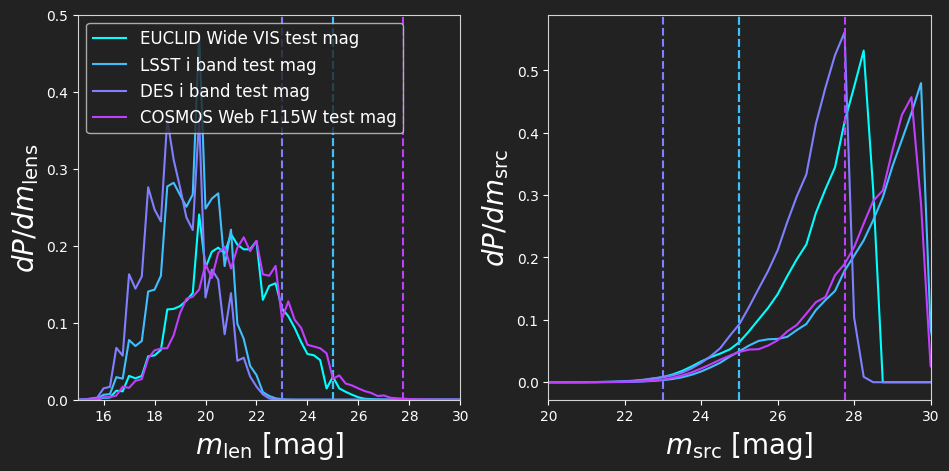

In [2]:
s  = ['EUCLID Wide VIS test mag', 'LSST i band test mag', 'DES i band test mag', 'COSMOS Web F115W test mag']#]

M_array = -1 * np.arange(15 , 23 , 0.25)
zl_array_test_mag = np.arange(0.0 , 2.1 , 0.1)
zs_array_test_mag = np.arange(0.0 , 5.6 , 0.2) 
sg_array_test_mag = np.linspace(100 , 400 , 31)

min_SNR     = 20
arc_mu_thr  = 3

############################################################################################################################################
for title in s:
    survey_params = utils.read_survey_params(' '.join(title.split()[:-2]), VERBOSE = 0)
    limit    = survey_params['limit']
    cut      = survey_params['cut']
    area     = survey_params['area']
    seeing   = survey_params['seeing']
    exp_time_sec = survey_params['exp_time_sec']
    zero_point_m = survey_params['zero_point_m']
    sky_bckgnd_m = survey_params['sky_bckgnd_m']
    photo_band   = survey_params['photo_band']

    try:
        #raise(ValueError)
        matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    except ValueError:
        print('FILE do NOT exist - RUNNING MODEL')
        matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_test_mag, zl_array_test_mag, zs_array_test_mag, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = False, SIE_FLAG = True)          
        print('FILE do NOT exist - RUNNING MODEL LL')                                                                                                                                    
        matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_test_mag, zl_array_test_mag, zs_array_test_mag, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = True, SIE_FLAG = False)

        utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)
############################################################################################################################################

from scipy import integrate
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

def get_src_magnitude_distr(m_obs, m_cut, zs_array, prob, M_array_UV, obs_band = 'sdss_i0'):
    m_num = np.zeros(len(m_obs))
    M_array_UV   = M_array_UV[::-1] if (M_array_UV[0]>M_array_UV[-1]) else M_array_UV
    for izs, zs in enumerate(zs_array[zs_array>0]):
        obs_band_to_intr_UV_corr = 5 * np.log10(cosmo.luminosity_distance(zs).value * 1e5) + ls.K_correction_from_UV(zs, obs_band, M_array_UV) 
        m_array_i = M_array_UV + obs_band_to_intr_UV_corr - 2.5 * np.log10(3)
        idcut = int(np.argmin(np.power(m_array_i-m_cut,2)))
        N_per_M = prob[izs][:][:][:]
        N_per_M[:][:][idcut-1:] = 0
        N_per_M = np.sum(N_per_M, axis=(0,1))
        if(0):
            print(f'z : {zs}')
            print(m_array_i[:6])
            print(N_per_M[:6])
            print(f'##########################################')
        for imu, mu in enumerate(m_array_i):
            m_idx = int(np.argmin(np.abs(m_obs - mu)))
            m_num[m_idx] = m_num[m_idx]+np.sum(N_per_M[imu])
    return m_num

color = iter(cm.cool(np.linspace(0, 1, len(s)+1)))
for iit, title in enumerate(s):
    ccc = next(color)
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    survey_params = utils.read_survey_params(title, VERBOSE = 0)
    limit    = survey_params['limit']
    cut      = survey_params['cut']
    photo_band   = survey_params['photo_band']
    print(title, limit, cut)
    m_obs = np.arange(15, 35, 0.5)
    mtest = ls.get_src_magnitude_distr(m_obs, cut, zs_array_test_mag, prob_noLL, M_array, obs_band = photo_band)
    mtes_ = ls.get_len_magnitude_distr(m_obs, zl_array_test_mag, sg_array_test_mag, matrix_noLL, obs_band = photo_band)
    
    print(int(np.sum(matrix_noLL)), int(np.sum(mtest)), int(np.sum(mtes_)))

lens_plot.plot_lens_src_magnitudes(s, zl_array_test_mag, zs_array_test_mag, sg_array_test_mag, M_array, AVG_MAGNIF_3 = 0, LENS_LIGHT = 0, PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)
#lens_plot.plot_lens_src_magnitudes(s, zl_array, zs_array, sigma_array, M_array, AVG_MAGNIF_3 = 0, LENS_LIGHT = 1, PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)

In [3]:
M_array     = np.linspace(-13 , -25 , 25)
sigma_array = np.linspace(100 , 400 , 31)
zl_array    = np.arange(0.  , 2.5 , 0.1)
zs_array    = np.arange(0.  , 5.4 , 0.2)

#sigma_array = np.linspace(100 , 400 , 21)
#zl_array    = np.linspace(0.  , 2.5 , 26)
#zs_array    = np.linspace(0.  , 7.  , 29)

min_SNR     = 20
arc_mu_thr  = 3
 
surveys_titles = [
     'COSMOS Web F115W', 'COSMOS Web F150W', 'COSMOS Web F277W', 
     'PEARLS NEP F115W', 'PEARLS NEP F150W', 'PEARLS NEP F277W',
     'JADES Deep F115W', 'JADES Deep F150W', 'JADES Deep F277W',
     'COSMOS HST i band',
     'DES i band', 
     'SUBARU HSC SuGOHI i band',
     'EUCLID Wide VIS', 
     'Roman HLWA J', 
     'LSST i band',]

Area: 1.60 deg^2, Expected number of galaxies: 93 (68)


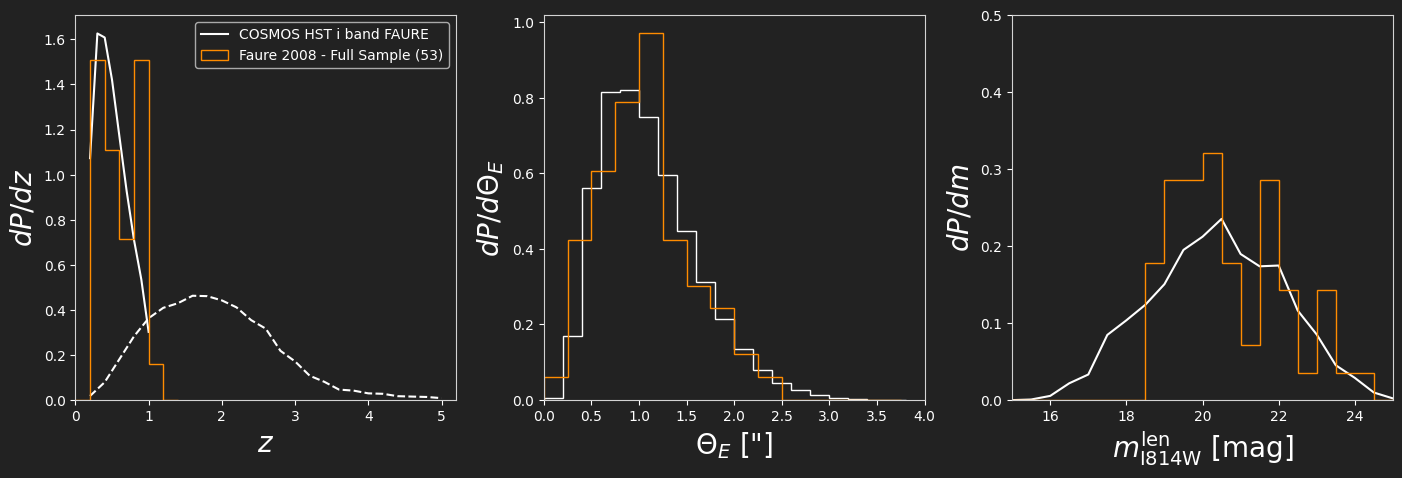

In [4]:
### COMPUTING FAURE COSMOS HST DISTRIBUTION ###
survey_params = utils.read_survey_params('COSMOS HST i band', VERBOSE = 0)
limit    = survey_params['limit']
cut      = survey_params['cut']
area     = survey_params['area']
seeing   = survey_params['seeing']
exp_time_sec = survey_params['exp_time_sec']
zero_point_m = survey_params['zero_point_m']
sky_bckgnd_m = survey_params['sky_bckgnd_m']
photo_band   = survey_params['photo_band']

zl_array_Faure = np.linspace(0.2 , 1.0 , 9)
zs_array_Faure = np.linspace(0.2 , 5   , 25) 
sg_array_Faure = np.linspace(150 , 400 , 26) #sort of equiv to M_V<-20

title = 'COSMOS HST i band FAURE'
try:
    #raise(ValueError)
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
except ValueError:
    print('FILE do NOT exist - RUNNING MODEL')
    matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                sg_array_Faure, zl_array_Faure, zs_array_Faure, M_array, limit, area, 
                                                                seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                LENS_LIGHT_FLAG = False, SIE_FLAG = True)          
    print('FILE do NOT exist - RUNNING MODEL LL')                                                                                                                                    
    matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                sg_array_Faure, zl_array_Faure, zs_array_Faure, M_array, limit, area, 
                                                                seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                LENS_LIGHT_FLAG = True, SIE_FLAG = False)

    utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)

print(f'Area: {area:.2f} deg^2, Expected number of galaxies: {np.sum(matrix_noLL):.0f} ({np.sum(matrix_LL):.0f})')
#utils.print_summary_surveys(['COSMOS HST i band'])
m_obs = np.linspace(15, 30, 31)
lens_plot.compare_COSMOS_HST_Faure(zl_array_Faure, zs_array_Faure, sg_array_Faure, M_array, cut, ONLY_FULL_SAMPLE = 1, LENS_LIGHT = 0, __MAG_OVER_ARCSEC_SQ__ = 0, PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)
#lens_plot.compare_COSMOS_HST_Faure(zl_array_Faure, zs_array_Faure, sg_array_Faure, M_array, cut, ONLY_FULL_SAMPLE = 1, LENS_LIGHT = 1, __MAG_OVER_ARCSEC_SQ__ = 0, PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)

|     Survey - Filter     | PSF/Seeing ["] | Area [deg^2] | m_cut [mag] | m_lim [mag] | N [deg^-1] | N_lenses (LL)      |

|      CFHTLS i band      |           0.620|       170.000|         23.0|         25.1|           3|      552 (      424)



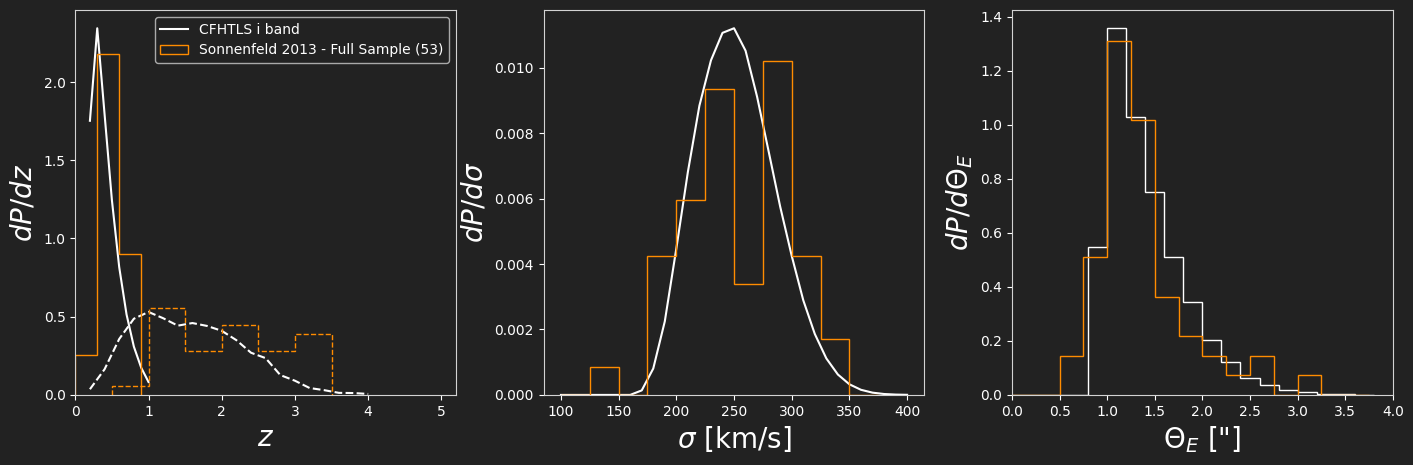

In [5]:
### COMPUTING Sonnenfeld SL2S DISTRIBUTION ###
title = 'CFHTLS i band'
survey_params = utils.read_survey_params('CFHTLS i band', VERBOSE = 0)
limit    = survey_params['limit']
cut      = survey_params['cut']
area     = survey_params['area']
seeing   = survey_params['seeing']
exp_time_sec = survey_params['exp_time_sec']
zero_point_m = survey_params['zero_point_m']
sky_bckgnd_m = survey_params['sky_bckgnd_m']
photo_band   = survey_params['photo_band']

zl_array_CFHTLS = np.linspace(0.2 , 1.0 , 9)
zs_array_CFHTLS = np.linspace(0.2 , 4   , 20) 
sg_array_CFHTLS = np.linspace(100 , 400 , 31) 

try:
    #raise(ValueError)
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
except ValueError:
    print('FILE do NOT exist - RUNNING MODEL')
    matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                LENS_LIGHT_FLAG = False, SIE_FLAG = True)          
    print('FILE do NOT exist - RUNNING MODEL LL')                                                                                                                                    
    matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                LENS_LIGHT_FLAG = True, SIE_FLAG = False)

    utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)
utils.print_summary_surveys([title])
lens_plot.compare_Sl2S(zl_array_CFHTLS, zs_array_CFHTLS, sg_array_CFHTLS, LENS_LIGHT = 0,  PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)
#lens_plot.compare_COSMOS_HST_Faure(zl_array_CFHTLS, zs_array_CFHTLS, sg_array_CFHTLS, M_array, cut, LENS_LIGHT = 1, PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)

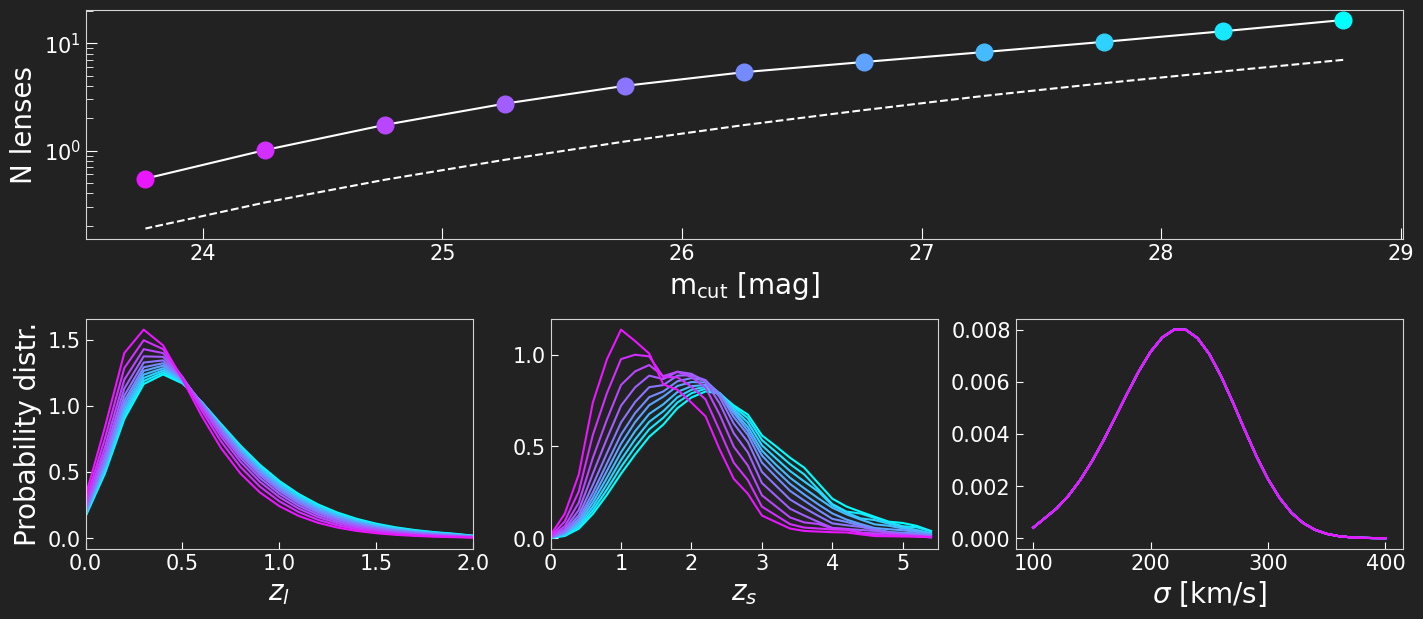

In [6]:
### COMPUTING effect of m_cut on the number of lenses and the parameters distributions ###
LENS_DENSITY  = 0
title = 'PEARLS NEP F115W'
survey_params = utils.read_survey_params(title, VERBOSE = 0)
arc_mu_thr = 3
min_SNR    = 20
limit    = survey_params['limit']
cut      = survey_params['cut']
area     = survey_params['area']
seeing   = survey_params['seeing']
exp_time_sec = survey_params['exp_time_sec']
zero_point_m = survey_params['zero_point_m']
sky_bckgnd_m = survey_params['sky_bckgnd_m']
photo_band   = survey_params['photo_band']

zl_array_CFHTLS = np.arange(0.0 , 2.1 , 0.1)
zs_array_CFHTLS = np.arange(0.0 , 5.6 , 0.2) 
sg_array_CFHTLS = np.linspace(100 , 400 , 31) 


_title_ = 'PEARLS NEP F115W band_mcut_'
delta_cut_limit = np.arange(0, 5.25, 0.5)
gal_num_vs_mcut, gal_num_vs_mcut_LL = np.zeros(0), np.zeros(0)

for iid, dlt in enumerate(delta_cut_limit):
    cut   = limit - dlt
    title = _title_ + str(iid)
    try:
        #raise(ValueError)
        matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    except ValueError:
        #print('FILE do NOT exist - RUNNING MODEL')
        matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = False, SIE_FLAG = True)          
        print('FILE do NOT exist - RUNNING MODEL LL')                                                                                                                                    
        matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = True, SIE_FLAG = False)

        utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)
    
    gal_num_vs_mcut = np.append(gal_num_vs_mcut, np.sum(matrix_noLL))
    gal_num_vs_mcut_LL = np.append(gal_num_vs_mcut_LL, np.sum(matrix_LL))

line_c, cmap_c, _col_, col_A, col_B, col_C, col_D, fn_prefix = lens_plot.set_plt_param(___PLOT_FOR_KEYNOTE___)
_c_ = 'w' if ___PLOT_FOR_KEYNOTE___ else 'k'

fig = plt.figure(figsize=(17, 7))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.35)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
ax4 = fig.add_subplot(grid[1, 2])

if LENS_DENSITY:
    ax1.plot(limit - delta_cut_limit, gal_num_vs_mcut/area, c = _c_)
    ax1.plot(limit - delta_cut_limit, gal_num_vs_mcut_LL/area, c = _c_, ls='--')
else:
    ax1.plot(limit - delta_cut_limit, gal_num_vs_mcut, c = _c_)
    ax1.plot(limit - delta_cut_limit, gal_num_vs_mcut_LL, c = _c_, ls='--')

_col_  = iter(cmap_c(np.linspace(0, 1, len(delta_cut_limit)+1)))
for iid, dlt in enumerate(delta_cut_limit):
    ccc = next(_col_)
    title = _title_ + str(iid)
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    _ , __  , ___, P_zs_LL   , P_zl_LL  , P_sg_LL   = ls.get_N_and_P_projections(matrix_LL, sigma_array, zl_array, zs_array, SMOOTH=1)
    _ , __  , ___, P_zs_noLL , P_zl_noLL  , P_sg_noLL   = ls.get_N_and_P_projections(matrix_noLL, sigma_array, zl_array, zs_array, SMOOTH=1)

    if LENS_DENSITY:
        ax1.plot(limit - dlt, np.sum(matrix_noLL)/area, marker='o', c = ccc, ms = 12)
    else:
        ax1.plot(limit - dlt, np.sum(matrix_noLL), marker='o', c = ccc, ms = 12)

    if(1):
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_noLL), c=ccc, ls='-', label=str(limit - dlt))
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_noLL), c=ccc, ls='-')
        ax4.plot(sg_array_CFHTLS, P_sg_noLL, c=ccc, ls='-')
    else:
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_LL), c=ccc, ls='--')
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_LL), c=ccc, ls='--')
        ax4.plot(sg_array_CFHTLS, P_sg_LL, c=ccc, ls='--')

ax1.set_yscale('log')
ax2.set_xlim((0, 2.0))
ax3.set_xlim((0, 5.5))

__size_labels__, __size_ticks__ = 20, 15
ax1.set_xlabel(r'm$_\text{cut}$ [mag]', fontsize=__size_labels__)
if LENS_DENSITY: ax1.set_ylabel(r'N lenses [deg$^{-2}$]' , fontsize=__size_labels__)
else: ax1.set_ylabel(r'N lenses' , fontsize=__size_labels__)
ax2.set_xlabel(r'$z_l$'    , fontsize=__size_labels__) 
ax3.set_xlabel(r'$z_s$'    , fontsize=__size_labels__) 
ax4.set_xlabel(r'$\sigma$ [km/s]', fontsize=__size_labels__) 
if(0):
    ax2.set_ylabel(r'$dP/dz_l$', fontsize=__size_labels__)
    ax3.set_ylabel(r'$dP/dz_s$', fontsize=__size_labels__)
    ax4.set_ylabel(r'$dP/d\sigma$'   , fontsize=__size_labels__)
else:
    ax2.set_ylabel(r'Probability distr.', fontsize=__size_labels__)

ax1.tick_params(axis='both', which = 'major', labelsize=__size_ticks__, direction = 'in', length = 8)
ax1.tick_params(axis='both', which = 'minor', labelsize=__size_ticks__, direction = 'in', length = 5)

ax2.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax3.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax4.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)

plt.show()

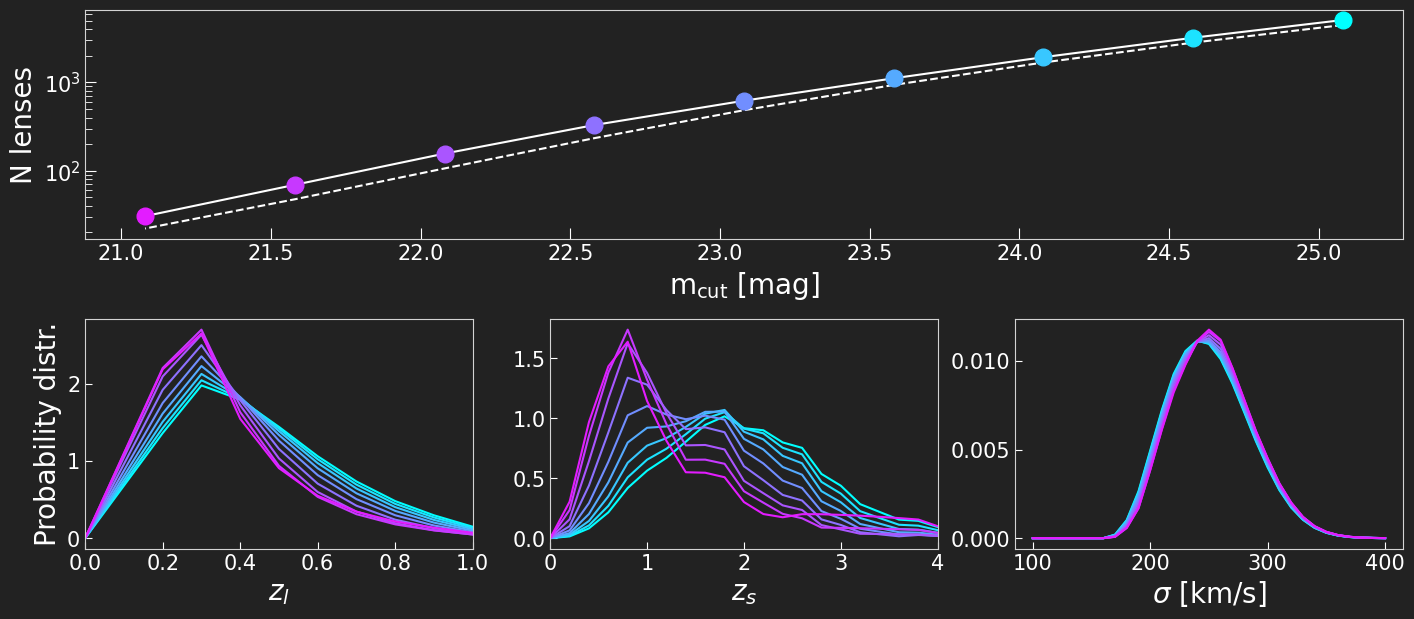

In [7]:
### COMPUTING effect of m_cut on the number of lenses and the parameters distributions ###
title = 'CFHTLS i band'
survey_params = utils.read_survey_params('CFHTLS i band', VERBOSE = 0)
arc_mu_thr = 3
min_SNR    = 20
limit    = survey_params['limit']
cut      = survey_params['cut']
area     = survey_params['area']
seeing   = survey_params['seeing']
exp_time_sec = survey_params['exp_time_sec']
zero_point_m = survey_params['zero_point_m']
sky_bckgnd_m = survey_params['sky_bckgnd_m']
photo_band   = survey_params['photo_band']

zl_array_CFHTLS = np.linspace(0.2 , 1.0 , 9)
zs_array_CFHTLS = np.linspace(0.2 , 4   , 20) 
sg_array_CFHTLS = np.linspace(100 , 400 , 31) 


_title_ = 'CFHTLS i band_mcut_'
delta_cut_limit = np.arange(0, 4.25, 0.5)
gal_num_vs_mcut, gal_num_vs_mcut_LL = np.zeros(0), np.zeros(0)

for iid, dlt in enumerate(delta_cut_limit):
    cut   = limit - dlt
    title = _title_ + str(iid)
    try:
        #raise(ValueError)
        matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    except ValueError:
        #print('FILE do NOT exist - RUNNING MODEL')
        matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = False, SIE_FLAG = True)          
        print('FILE do NOT exist - RUNNING MODEL LL')                                                                                                                                    
        matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = True, SIE_FLAG = False)

        utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)
    
    gal_num_vs_mcut = np.append(gal_num_vs_mcut, np.sum(matrix_noLL))
    gal_num_vs_mcut_LL = np.append(gal_num_vs_mcut_LL, np.sum(matrix_LL))

line_c, cmap_c, _col_, col_A, col_B, col_C, col_D, fn_prefix = lens_plot.set_plt_param(___PLOT_FOR_KEYNOTE___)
_c_ = 'w' if ___PLOT_FOR_KEYNOTE___ else 'k'

fig = plt.figure(figsize=(17, 7))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.35)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
ax4 = fig.add_subplot(grid[1, 2])

ax1.plot(limit - delta_cut_limit, gal_num_vs_mcut, c = _c_)
ax1.plot(limit - delta_cut_limit, gal_num_vs_mcut_LL, c = _c_, ls='--')

_col_  = iter(cmap_c(np.linspace(0, 1, len(delta_cut_limit)+1)))
for iid, dlt in enumerate(delta_cut_limit):
    ccc = next(_col_)
    title = _title_ + str(iid)
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    _ , __  , ___, P_zs_LL   , P_zl_LL  , P_sg_LL   = ls.get_N_and_P_projections(matrix_LL, sigma_array, zl_array, zs_array, SMOOTH=1)
    _ , __  , ___, P_zs_noLL , P_zl_noLL  , P_sg_noLL   = ls.get_N_and_P_projections(matrix_noLL, sigma_array, zl_array, zs_array, SMOOTH=1)

    ax1.plot(limit - dlt, np.sum(matrix_noLL), marker='o', c = ccc, ms = 12)

    if(1):
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_noLL), c=ccc, ls='-', label=str(limit - dlt))
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_noLL), c=ccc, ls='-')
        ax4.plot(sg_array_CFHTLS, P_sg_noLL, c=ccc, ls='-')
    else:
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_LL), c=ccc, ls='--')
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_LL), c=ccc, ls='--')
        ax4.plot(sg_array_CFHTLS, P_sg_LL, c=ccc, ls='--')

ax1.set_yscale('log')
ax2.set_xlim((0,1.))
ax3.set_xlim((0,4.))

__size_labels__, __size_ticks__ = 20, 15
ax1.set_xlabel(r'm$_\text{cut}$ [mag]', fontsize=__size_labels__)
ax1.set_ylabel(r'N lenses' , fontsize=__size_labels__)
ax2.set_xlabel(r'$z_l$'    , fontsize=__size_labels__) 
ax3.set_xlabel(r'$z_s$'    , fontsize=__size_labels__) 
ax4.set_xlabel(r'$\sigma$ [km/s]', fontsize=__size_labels__) 
if(0):
    ax2.set_ylabel(r'$dP/dz_l$', fontsize=__size_labels__)
    ax3.set_ylabel(r'$dP/dz_s$', fontsize=__size_labels__)
    ax4.set_ylabel(r'$dP/d\sigma$'   , fontsize=__size_labels__)
else:
    ax2.set_ylabel(r'Probability distr.', fontsize=__size_labels__)

ax1.tick_params(axis='both', which = 'major', labelsize=__size_ticks__, direction = 'in', length = 8)
ax1.tick_params(axis='both', which = 'minor', labelsize=__size_ticks__, direction = 'in', length = 5)

ax2.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax3.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax4.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)

plt.show()

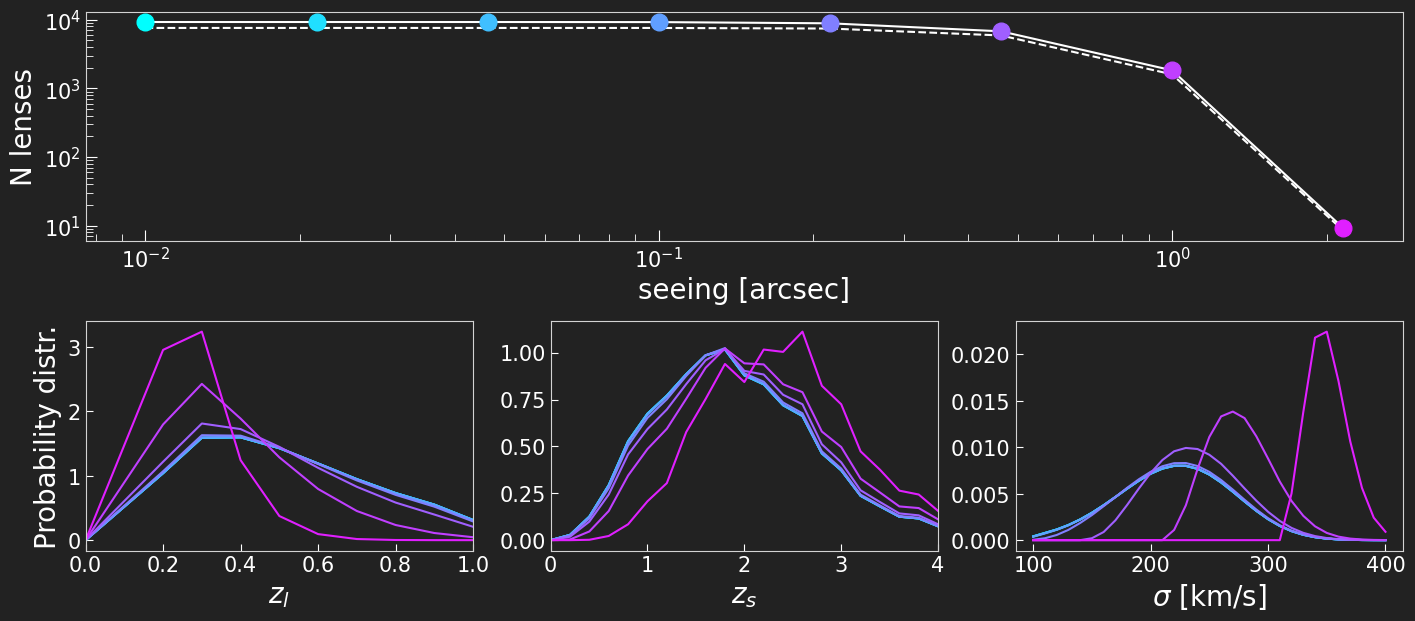

In [8]:
### COMPUTING effect of seeing on the number of lenses and the parameters distributions ###
title = 'CFHTLS i band'
survey_params = utils.read_survey_params('CFHTLS i band', VERBOSE = 0)
arc_mu_thr = 3
min_SNR    = 20
limit    = survey_params['limit']
cut      = survey_params['cut']
area     = survey_params['area']
#seeing   = survey_params['seeing']
exp_time_sec = survey_params['exp_time_sec']
zero_point_m = survey_params['zero_point_m']
sky_bckgnd_m = survey_params['sky_bckgnd_m']
photo_band   = survey_params['photo_band']

zl_array_CFHTLS = np.linspace(0.2 , 1.0 , 9)
zs_array_CFHTLS = np.linspace(0.2 , 4   , 20) 
sg_array_CFHTLS = np.linspace(100 , 400 , 31) 

_title_ = 'CFHTLS i band_seeing_'
cut   = limit
seeing_array = np.logspace(-2, 1, 10)[:8]
gal_num_vs_mcut, gal_num_vs_mcut_LL = np.zeros(0), np.zeros(0)

for sid, seeing in enumerate(seeing_array):
    title = _title_ + str(sid)
    try:
        #raise(ValueError)
        matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    except ValueError:
        #print('FILE do NOT exist - RUNNING MODEL')
        matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = False, SIE_FLAG = True)          
        print('FILE do NOT exist - RUNNING MODEL LL')                                                                                                                                    
        matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = True, SIE_FLAG = False)

        utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)
    
    gal_num_vs_mcut = np.append(gal_num_vs_mcut, np.sum(matrix_noLL))
    gal_num_vs_mcut_LL = np.append(gal_num_vs_mcut_LL, np.sum(matrix_LL))

line_c, cmap_c, _col_, col_A, col_B, col_C, col_D, fn_prefix = lens_plot.set_plt_param(___PLOT_FOR_KEYNOTE___)
_c_ = 'w' if ___PLOT_FOR_KEYNOTE___ else 'k'

fig = plt.figure(figsize=(17, 7))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.35)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
ax4 = fig.add_subplot(grid[1, 2])

ax1.plot(seeing_array, gal_num_vs_mcut, c = _c_)
ax1.plot(seeing_array, gal_num_vs_mcut_LL, c = _c_, ls='--')

_col_  = iter(cmap_c(np.linspace(0, 1, len(seeing_array)+1)))
for sid, seeing in enumerate(seeing_array):
    ccc = next(_col_)
    title = _title_ + str(sid)
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    _ , __  , ___, P_zs_LL   , P_zl_LL  , P_sg_LL   = ls.get_N_and_P_projections(matrix_LL, sigma_array, zl_array, zs_array, SMOOTH=1)
    _ , __  , ___, P_zs_noLL , P_zl_noLL  , P_sg_noLL   = ls.get_N_and_P_projections(matrix_noLL, sigma_array, zl_array, zs_array, SMOOTH=1)

    ax1.plot(seeing, np.sum(matrix_noLL), marker='o', c = ccc, ms = 12)

    if(1):
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_noLL), c=ccc, ls='-', label=str(limit - dlt))
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_noLL), c=ccc, ls='-')
        ax4.plot(sg_array_CFHTLS, P_sg_noLL, c=ccc, ls='-')
    else:
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_LL), c=ccc, ls='--')
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_LL), c=ccc, ls='--')
        ax4.plot(sg_array_CFHTLS, P_sg_LL, c=ccc, ls='--')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlim((0,1.))
ax3.set_xlim((0,4.))

__size_labels__, __size_ticks__ = 20, 15
ax1.set_xlabel(r'seeing [arcsec]', fontsize=__size_labels__)
ax1.set_ylabel(r'N lenses' , fontsize=__size_labels__)
ax2.set_xlabel(r'$z_l$'    , fontsize=__size_labels__) 
ax3.set_xlabel(r'$z_s$'    , fontsize=__size_labels__) 
ax4.set_xlabel(r'$\sigma$ [km/s]', fontsize=__size_labels__) 
if(0):
    ax2.set_ylabel(r'$dP/dz_l$', fontsize=__size_labels__)
    ax3.set_ylabel(r'$dP/dz_s$', fontsize=__size_labels__)
    ax4.set_ylabel(r'$dP/d\sigma$'   , fontsize=__size_labels__)
else:
    ax2.set_ylabel(r'Probability distr.', fontsize=__size_labels__)

ax1.tick_params(axis='both', which = 'major', labelsize=__size_ticks__, direction = 'in', length = 8)
ax1.tick_params(axis='both', which = 'minor', labelsize=__size_ticks__, direction = 'in', length = 5)

ax2.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax3.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax4.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)

plt.show()

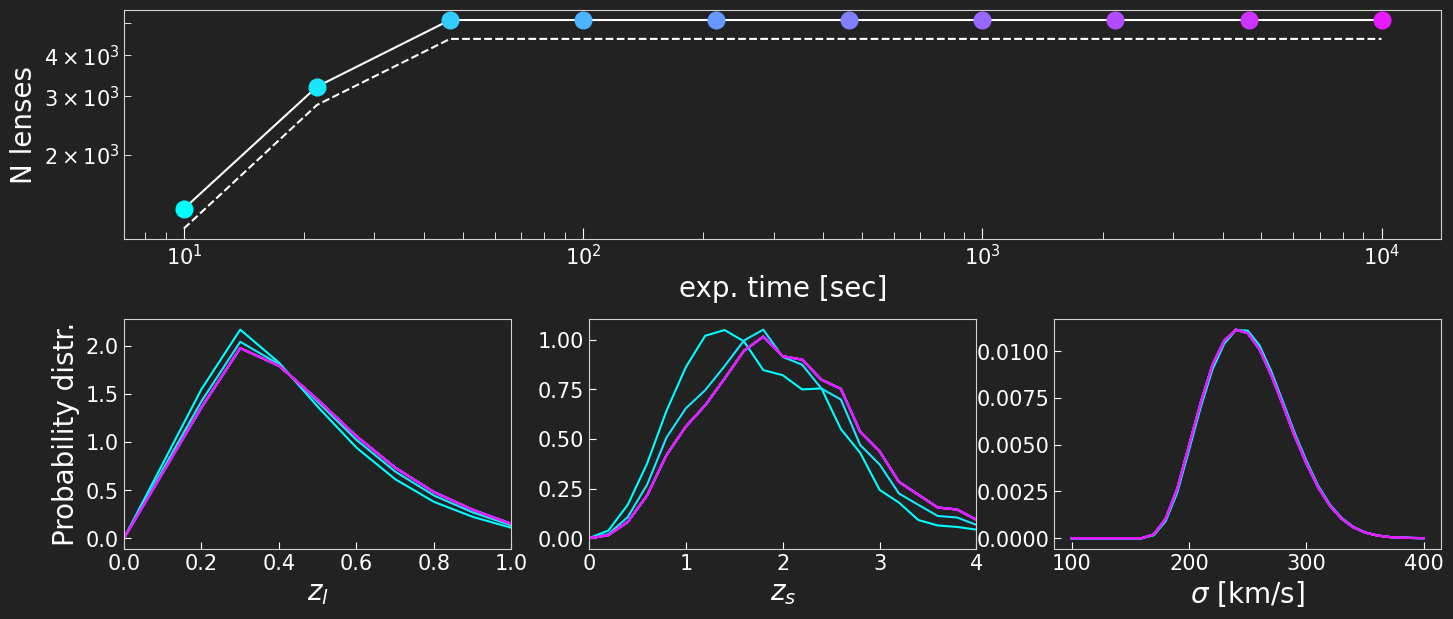

In [9]:
### COMPUTING effect of exp.time on the number of lenses and the parameters distributions ###
title = 'CFHTLS i band'
survey_params = utils.read_survey_params('CFHTLS i band', VERBOSE = 0)
arc_mu_thr = 3
min_SNR    = 20
limit    = survey_params['limit']
cut      = survey_params['cut']
area     = survey_params['area']
seeing   = survey_params['seeing']
#exp_time_sec = survey_params['exp_time_sec']
zero_point_m = survey_params['zero_point_m']
sky_bckgnd_m = survey_params['sky_bckgnd_m']
photo_band   = survey_params['photo_band']

zl_array_CFHTLS = np.linspace(0.2 , 1.0 , 9)
zs_array_CFHTLS = np.linspace(0.2 , 4   , 20) 
sg_array_CFHTLS = np.linspace(100 , 400 , 31) 

_title_ = 'CFHTLS i band_exposure_time_'
cut   = limit
exp_time_sec_array = np.logspace(1, 4, 10)
gal_num_vs_mcut, gal_num_vs_mcut_LL = np.zeros(0), np.zeros(0)

for tid, exp_time_sec in enumerate(exp_time_sec_array):
    title = _title_ + str(tid)
    try:
        #raise(ValueError)
        matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    except ValueError:
        #print('FILE do NOT exist - RUNNING MODEL')
        matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = False, SIE_FLAG = True)          
        print('FILE do NOT exist - RUNNING MODEL LL')                                                                                                                                    
        matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = True, SIE_FLAG = False)

        utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)
    
    gal_num_vs_mcut = np.append(gal_num_vs_mcut, np.sum(matrix_noLL))
    gal_num_vs_mcut_LL = np.append(gal_num_vs_mcut_LL, np.sum(matrix_LL))

line_c, cmap_c, _col_, col_A, col_B, col_C, col_D, fn_prefix = lens_plot.set_plt_param(___PLOT_FOR_KEYNOTE___)
_c_ = 'w' if ___PLOT_FOR_KEYNOTE___ else 'k'

fig = plt.figure(figsize=(17, 7))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.35)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
ax4 = fig.add_subplot(grid[1, 2])

ax1.plot(exp_time_sec_array, gal_num_vs_mcut, c = _c_)
ax1.plot(exp_time_sec_array, gal_num_vs_mcut_LL, c = _c_, ls='--')

_col_  = iter(cmap_c(np.linspace(0, 1, len(exp_time_sec_array)+1)))
for eid, exp_time_sec in enumerate(exp_time_sec_array):
    ccc = next(_col_)
    title = _title_ + str(eid)
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    _ , __  , ___, P_zs_LL   , P_zl_LL  , P_sg_LL   = ls.get_N_and_P_projections(matrix_LL, sigma_array, zl_array, zs_array, SMOOTH=1)
    _ , __  , ___, P_zs_noLL , P_zl_noLL  , P_sg_noLL   = ls.get_N_and_P_projections(matrix_noLL, sigma_array, zl_array, zs_array, SMOOTH=1)

    ax1.plot(exp_time_sec, np.sum(matrix_noLL), marker='o', c = ccc, ms = 12)

    if(1):
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_noLL), c=ccc, ls='-', label=str(limit - dlt))
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_noLL), c=ccc, ls='-')
        ax4.plot(sg_array_CFHTLS, P_sg_noLL, c=ccc, ls='-')
    else:
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_LL), c=ccc, ls='--')
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_LL), c=ccc, ls='--')
        ax4.plot(sg_array_CFHTLS, P_sg_LL, c=ccc, ls='--')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlim((0,1.))
ax3.set_xlim((0,4.))

__size_labels__, __size_ticks__ = 20, 15
ax1.set_xlabel(r'exp. time [sec]', fontsize=__size_labels__)
ax1.set_ylabel(r'N lenses' , fontsize=__size_labels__)
ax2.set_xlabel(r'$z_l$'    , fontsize=__size_labels__) 
ax3.set_xlabel(r'$z_s$'    , fontsize=__size_labels__) 
ax4.set_xlabel(r'$\sigma$ [km/s]', fontsize=__size_labels__) 
if(0):
    ax2.set_ylabel(r'$dP/dz_l$', fontsize=__size_labels__)
    ax3.set_ylabel(r'$dP/dz_s$', fontsize=__size_labels__)
    ax4.set_ylabel(r'$dP/d\sigma$'   , fontsize=__size_labels__)
else:
    ax2.set_ylabel(r'Probability distr.', fontsize=__size_labels__)

ax1.tick_params(axis='both', which = 'major', labelsize=__size_ticks__, direction = 'in', length = 8)
ax1.tick_params(axis='both', which = 'minor', labelsize=__size_ticks__, direction = 'in', length = 5)

ax2.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax3.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax4.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)

plt.show()

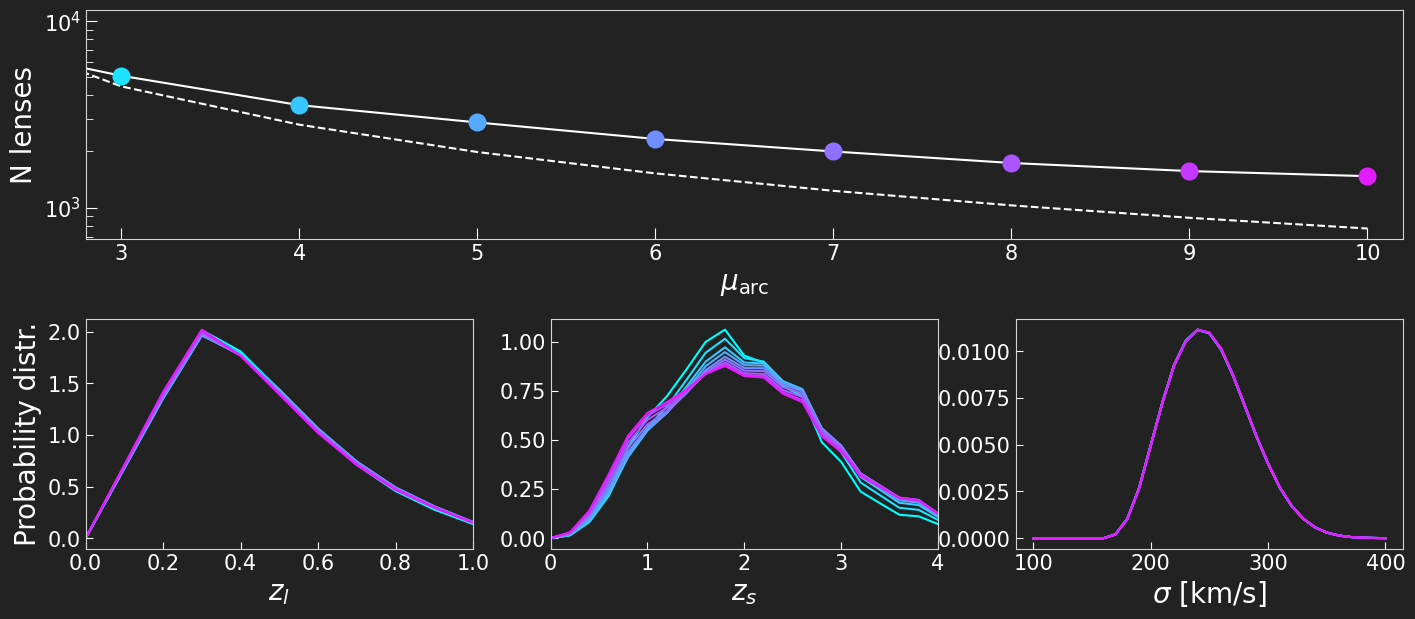

In [10]:
### COMPUTING effect of mu_arc on the number of lenses and the parameters distributions ###
title = 'CFHTLS i band'
#arc_mu_thr = 3
min_SNR    = 20
survey_params = utils.read_survey_params('CFHTLS i band', VERBOSE = 0)
limit    = survey_params['limit']
cut      = survey_params['cut']
area     = survey_params['area']
seeing   = survey_params['seeing']
exp_time_sec = survey_params['exp_time_sec']
zero_point_m = survey_params['zero_point_m']
sky_bckgnd_m = survey_params['sky_bckgnd_m']
photo_band   = survey_params['photo_band']

zl_array_CFHTLS = np.linspace(0.2 , 1.0 , 9)
zs_array_CFHTLS = np.linspace(0.2 , 4   , 20) 
sg_array_CFHTLS = np.linspace(100 , 400 , 31) 

_title_ = 'CFHTLS i band_mu_arc_'
cut   = limit
arc_mu_thr_array = np.arange(2, 11, 1)
gal_num_vs_mcut, gal_num_vs_mcut_LL = np.zeros(0), np.zeros(0)

for aid, arc_mu_thr in enumerate(arc_mu_thr_array):
    title = _title_ + str(aid)
    try:
        #raise(ValueError)
        matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    except ValueError:
        #print('FILE do NOT exist - RUNNING MODEL')
        matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = False, SIE_FLAG = True)          
        print('FILE do NOT exist - RUNNING MODEL LL')                                                                                                                                    
        matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = True, SIE_FLAG = False)

        utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)
    
    gal_num_vs_mcut = np.append(gal_num_vs_mcut, np.sum(matrix_noLL))
    gal_num_vs_mcut_LL = np.append(gal_num_vs_mcut_LL, np.sum(matrix_LL))

line_c, cmap_c, _col_, col_A, col_B, col_C, col_D, fn_prefix = lens_plot.set_plt_param(___PLOT_FOR_KEYNOTE___)
_c_ = 'w' if ___PLOT_FOR_KEYNOTE___ else 'k'

fig = plt.figure(figsize=(17, 7))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.35)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
ax4 = fig.add_subplot(grid[1, 2])

ax1.plot(arc_mu_thr_array, gal_num_vs_mcut, c = _c_)
ax1.plot(arc_mu_thr_array, gal_num_vs_mcut_LL, c = _c_, ls='--')

_col_  = iter(cmap_c(np.linspace(0, 1, len(arc_mu_thr_array)+1)))
for aid, arc_mu_thr in enumerate(arc_mu_thr_array):
    ccc = next(_col_)
    title = _title_ + str(aid)
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    _ , __  , ___, P_zs_LL   , P_zl_LL  , P_sg_LL   = ls.get_N_and_P_projections(matrix_LL, sigma_array, zl_array, zs_array, SMOOTH=1)
    _ , __  , ___, P_zs_noLL , P_zl_noLL  , P_sg_noLL   = ls.get_N_and_P_projections(matrix_noLL, sigma_array, zl_array, zs_array, SMOOTH=1)

    ax1.plot(arc_mu_thr, np.sum(matrix_noLL), marker='o', c = ccc, ms = 12)

    if(1):
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_noLL), c=ccc, ls='-', label=str(limit - dlt))
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_noLL), c=ccc, ls='-')
        ax4.plot(sg_array_CFHTLS, P_sg_noLL, c=ccc, ls='-')
    else:
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_LL), c=ccc, ls='--')
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_LL), c=ccc, ls='--')
        ax4.plot(sg_array_CFHTLS, P_sg_LL, c=ccc, ls='--')

#ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim((2.8,10.2))
ax2.set_xlim((0,1.))
ax3.set_xlim((0,4.))

__size_labels__, __size_ticks__ = 20, 15
ax1.set_xlabel(r'$\mu_\text{arc}$', fontsize=__size_labels__)
ax1.set_ylabel(r'N lenses' , fontsize=__size_labels__)
ax2.set_xlabel(r'$z_l$'    , fontsize=__size_labels__) 
ax3.set_xlabel(r'$z_s$'    , fontsize=__size_labels__) 
ax4.set_xlabel(r'$\sigma$ [km/s]', fontsize=__size_labels__) 
if(0):
    ax2.set_ylabel(r'$dP/dz_l$', fontsize=__size_labels__)
    ax3.set_ylabel(r'$dP/dz_s$', fontsize=__size_labels__)
    ax4.set_ylabel(r'$dP/d\sigma$'   , fontsize=__size_labels__)
else:
    ax2.set_ylabel(r'Probability distr.', fontsize=__size_labels__)

ax1.tick_params(axis='both', which = 'major', labelsize=__size_ticks__, direction = 'in', length = 8)
ax1.tick_params(axis='both', which = 'minor', labelsize=__size_ticks__, direction = 'in', length = 5)

ax2.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax3.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax4.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)

plt.show()

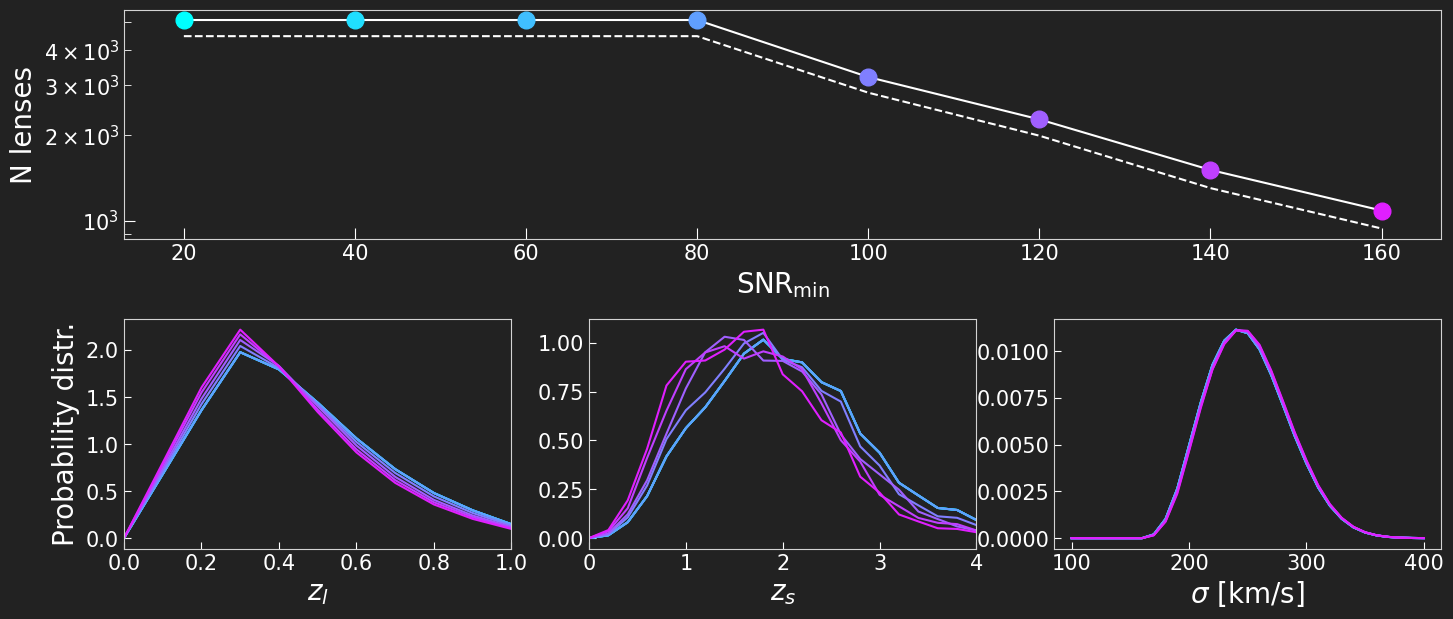

In [11]:
### COMPUTING effect of min_SNR on the number of lenses and the parameters distributions ###
title = 'CFHTLS i band'
survey_params = utils.read_survey_params('CFHTLS i band', VERBOSE = 0)
arc_mu_thr = 3
#min_SNR    = 20
limit    = survey_params['limit']
cut      = survey_params['cut']
area     = survey_params['area']
seeing   = survey_params['seeing']
exp_time_sec = survey_params['exp_time_sec']
zero_point_m = survey_params['zero_point_m']
sky_bckgnd_m = survey_params['sky_bckgnd_m']
photo_band   = survey_params['photo_band']

zl_array_CFHTLS = np.linspace(0.2 , 1.0 , 9)
zs_array_CFHTLS = np.linspace(0.2 , 4   , 20) 
sg_array_CFHTLS = np.linspace(100 , 400 , 31) 

_title_ = 'CFHTLS i band_SNR_'
cut   = limit
min_SNR_array = np.arange(20, 180, 20)
gal_num_vs_mcut, gal_num_vs_mcut_LL = np.zeros(0), np.zeros(0)

for SNRid, min_SNR in enumerate(min_SNR_array):
    title = _title_ + str(SNRid)
    try:
        #raise(ValueError)
        matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    except ValueError:
        #print('FILE do NOT exist - RUNNING MODEL')
        matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = False, SIE_FLAG = True)          
        print('FILE do NOT exist - RUNNING MODEL LL')                                                                                                                                    
        matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                    sg_array_CFHTLS, zl_array_CFHTLS, zs_array_CFHTLS, M_array, limit, area, 
                                                                    seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                    photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                    LENS_LIGHT_FLAG = True, SIE_FLAG = False)

        utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)
    
    gal_num_vs_mcut = np.append(gal_num_vs_mcut, np.sum(matrix_noLL))
    gal_num_vs_mcut_LL = np.append(gal_num_vs_mcut_LL, np.sum(matrix_LL))

line_c, cmap_c, _col_, col_A, col_B, col_C, col_D, fn_prefix = lens_plot.set_plt_param(___PLOT_FOR_KEYNOTE___)
_c_ = 'w' if ___PLOT_FOR_KEYNOTE___ else 'k'

fig = plt.figure(figsize=(17, 7))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.35)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])
ax4 = fig.add_subplot(grid[1, 2])

ax1.plot(min_SNR_array, gal_num_vs_mcut, c = _c_)
ax1.plot(min_SNR_array, gal_num_vs_mcut_LL, c = _c_, ls='--')

_col_  = iter(cmap_c(np.linspace(0, 1, len(min_SNR_array)+1)))
for SNRid, min_SNR in enumerate(min_SNR_array):
    ccc = next(_col_)
    title = _title_ + str(SNRid)
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
    _ , __  , ___, P_zs_LL   , P_zl_LL  , P_sg_LL   = ls.get_N_and_P_projections(matrix_LL, sigma_array, zl_array, zs_array, SMOOTH=1)
    _ , __  , ___, P_zs_noLL , P_zl_noLL  , P_sg_noLL   = ls.get_N_and_P_projections(matrix_noLL, sigma_array, zl_array, zs_array, SMOOTH=1)

    ax1.plot(min_SNR, np.sum(matrix_noLL), marker='o', c = ccc, ms = 12)

    if(1):
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_noLL), c=ccc, ls='-', label=str(limit - dlt))
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_noLL), c=ccc, ls='-')
        ax4.plot(sg_array_CFHTLS, P_sg_noLL, c=ccc, ls='-')
    else:
        ax2.plot(np.append(0,zl_array_CFHTLS), np.append(0,P_zl_LL), c=ccc, ls='--')
        ax3.plot(np.append(0,zs_array_CFHTLS), np.append(0,P_zs_LL), c=ccc, ls='--')
        ax4.plot(sg_array_CFHTLS, P_sg_LL, c=ccc, ls='--')

#ax1.set_xscale('log')
ax1.set_yscale('log')
#ax1.set_xlim((2.8,10.2))
ax2.set_xlim((0,1.))
ax3.set_xlim((0,4.))

__size_labels__, __size_ticks__ = 20, 15
ax1.set_xlabel(r'SNR$_\text{min}$', fontsize=__size_labels__)
ax1.set_ylabel(r'N lenses' , fontsize=__size_labels__)
ax2.set_xlabel(r'$z_l$'    , fontsize=__size_labels__) 
ax3.set_xlabel(r'$z_s$'    , fontsize=__size_labels__) 
ax4.set_xlabel(r'$\sigma$ [km/s]', fontsize=__size_labels__) 
if(0):
    ax2.set_ylabel(r'$dP/dz_l$', fontsize=__size_labels__)
    ax3.set_ylabel(r'$dP/dz_s$', fontsize=__size_labels__)
    ax4.set_ylabel(r'$dP/d\sigma$'   , fontsize=__size_labels__)
else:
    ax2.set_ylabel(r'Probability distr.', fontsize=__size_labels__)

ax1.tick_params(axis='both', which = 'major', labelsize=__size_ticks__, direction = 'in', length = 8)
ax1.tick_params(axis='both', which = 'minor', labelsize=__size_ticks__, direction = 'in', length = 5)

ax2.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax3.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)
ax4.tick_params(axis='both', which = 'both', labelsize=__size_ticks__, direction = 'in', length = 5)

plt.show()

Expecting 89 (92) lenses above z>0.5 in DES - noLL (LL)
|     Survey - Filter     | PSF/Seeing ["] | Area [deg^2] | m_cut [mag] | m_lim [mag] | N [deg^-1] | N_lenses (LL)      |

|       DES i band        |           0.960|      5000.000|         23.0|         24.7|           0|     1660 (      905)



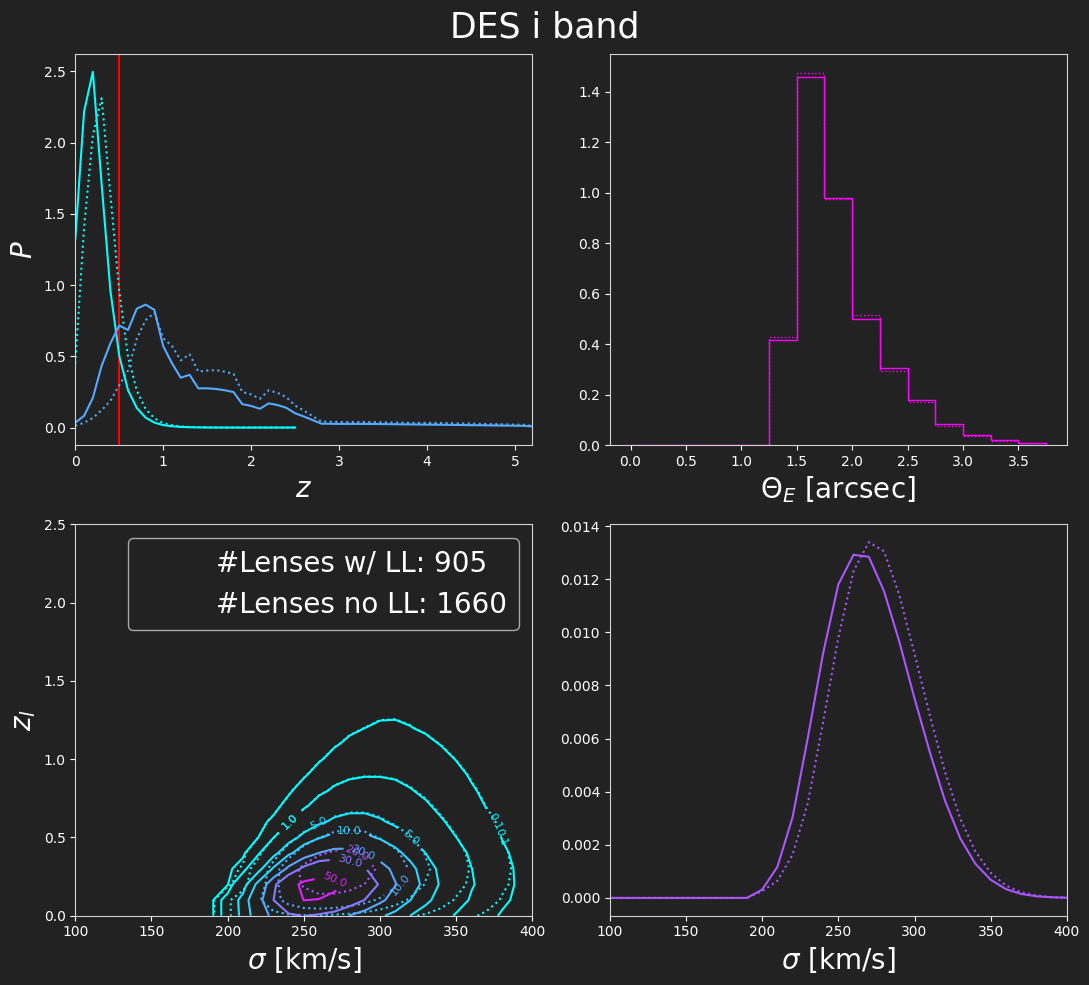

In [12]:
title = 'DES i band'
matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)

_, __, ___, ____, P_zl_LL, _____ = ls.get_N_and_P_projections(matrix_LL, sigma_array, zl_array, zs_array, SMOOTH = 1)
_, __, ___, ____, P_zl_noLL, _____ = ls.get_N_and_P_projections(matrix_noLL, sigma_array, zl_array, zs_array, SMOOTH = 1)

zl_tresh = 0.5
f_lens_LL, f_lens_noLL = np.sum(P_zl_LL[zl_array>zl_tresh]*np.diff(zl_array)[0]), np.sum(P_zl_noLL[zl_array>zl_tresh]*np.diff(zl_array)[0])
N_lens_LL, N_lens_noLL = np.sum(matrix_LL), np.sum(matrix_noLL)

print(f'Expecting {f_lens_noLL*N_lens_noLL:.0f} ({f_lens_LL*N_lens_LL:.0f}) lenses above z>{zl_tresh} in DES - noLL (LL)')

utils.print_summary_surveys([title])
lens_plot.set_plt_param(PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)
fig, ax = plt.subplots(2, 2, figsize=(11, 10), sharex=False, sharey=False)
plt.subplots_adjust(wspace=.15, hspace=.2)
ax[0,0].axvline(0.5, c='r')
lens_plot.plot_z_sigma_distributions(fig, ax, title, zl_array, zs_array, sigma_array,
                            Theta_E_LL, matrix_LL, Theta_E_noLL, matrix_noLL,
                            PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___, CONTOUR = 0, 
                            LOG = 0, SMOOTH = 1, SAVE = 1)
plt.show()

|     Survey - Filter     | PSF/Seeing ["] | Area [deg^2] | m_cut [mag] | m_lim [mag] | N [deg^-1] | N_lenses (LL)      |

|       DES i band        |           0.960|      5000.000|         23.0|         24.7|           0|     1660 (      905)



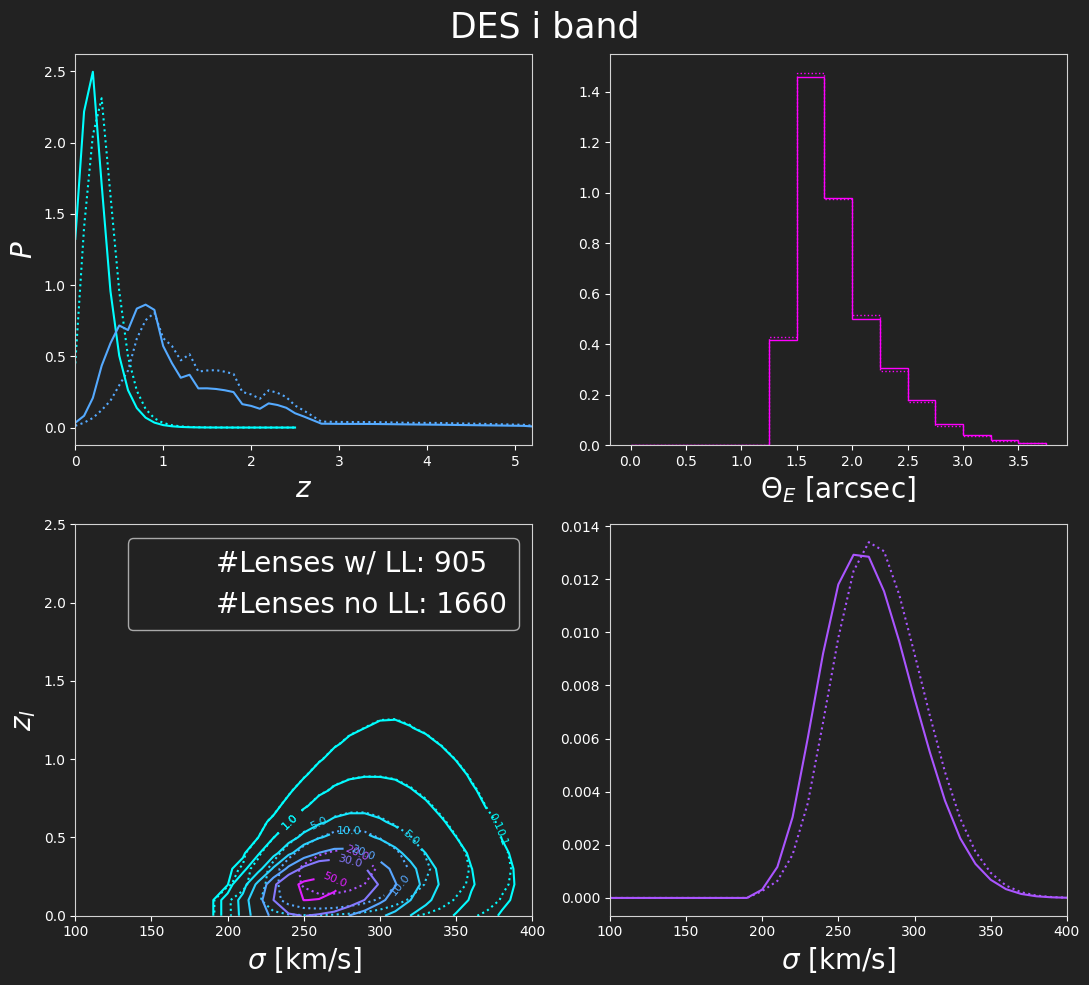

|     Survey - Filter     | PSF/Seeing ["] | Area [deg^2] | m_cut [mag] | m_lim [mag] | N [deg^-1] | N_lenses (LL)      |

|     EUCLID Wide VIS     |           0.170|     15000.000|         25.0|         26.2|          25|  3.7e+05 (  2.1e+05)



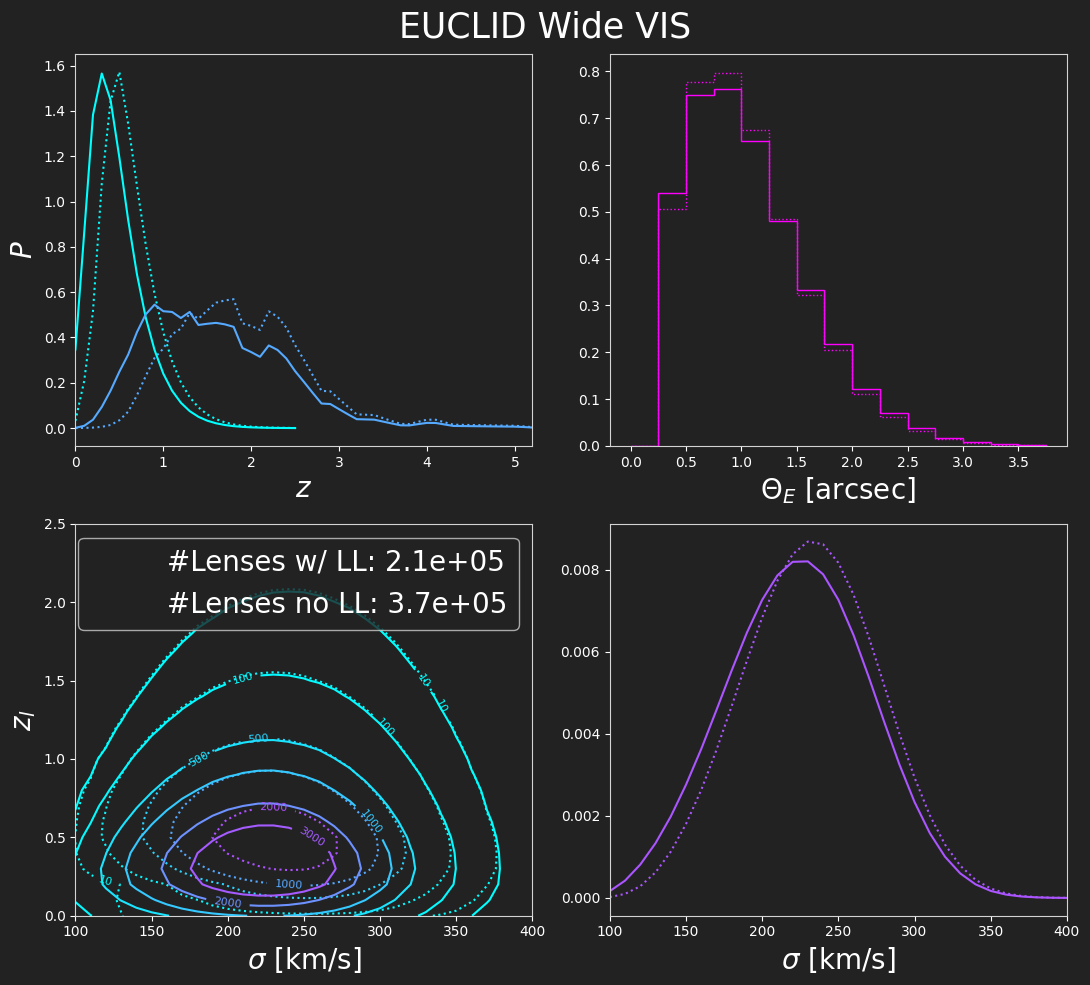

In [22]:
for title in ['DES i band', 'EUCLID Wide VIS']: #surveys_titles:
     survey_params = utils.read_survey_params(title, VERBOSE = 0)
     limit    = survey_params['limit']
     cut      = survey_params['cut']
     area     = survey_params['area']
     seeing   = survey_params['seeing']
     exp_time_sec = survey_params['exp_time_sec']
     zero_point_m = survey_params['zero_point_m']
     sky_bckgnd_m = survey_params['sky_bckgnd_m']
     photo_band   = survey_params['photo_band']

     try:
          matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(title)
     except ValueError:
          print('FILE do NOT exist - RUNNING MODEL')
          matrix_noLL, Theta_E_noLL, prob_noLL = ls.calculate_num_lenses_and_prob(
                                                                      sigma_array, zl_array, zs_array, M_array, limit, area, 
                                                                      seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m, 
                                                                      photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                      LENS_LIGHT_FLAG = False, SIE_FLAG = True)                                                                                                                                                                                                          
          matrix_LL, Theta_E_LL, prob_LL = ls.calculate_num_lenses_and_prob(
                                                                      sigma_array, zl_array, zs_array, M_array, limit, area, 
                                                                      seeing, min_SNR, exp_time_sec, sky_bckgnd_m, zero_point_m,
                                                                      photo_band = photo_band, mag_cut=cut, arc_mu_threshold = arc_mu_thr, 
                                                                      LENS_LIGHT_FLAG = True, SIE_FLAG = False)

          utils.save_pickled_files(title,  matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL)

     utils.print_summary_surveys([title])
     lens_plot.set_plt_param(PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)
     fig, ax = plt.subplots(2, 2, figsize=(11, 10), sharex=False, sharey=False)
     plt.subplots_adjust(wspace=.15, hspace=.2)
     lens_plot.plot_z_sigma_distributions(fig, ax, title, zl_array, zs_array, sigma_array,
                                   Theta_E_LL, matrix_LL, Theta_E_noLL, matrix_noLL,
                                   PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___, CONTOUR = 0, 
                                   LOG = 0, SMOOTH = 1, SAVE = 1)
     plt.show()

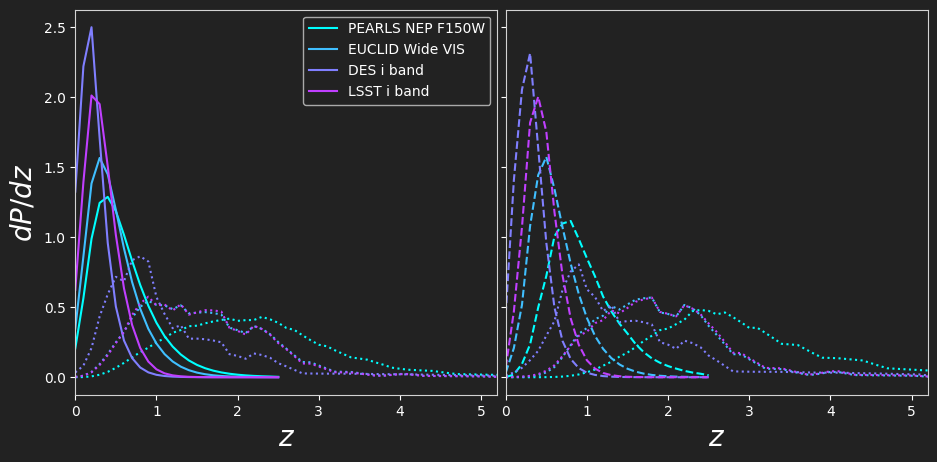

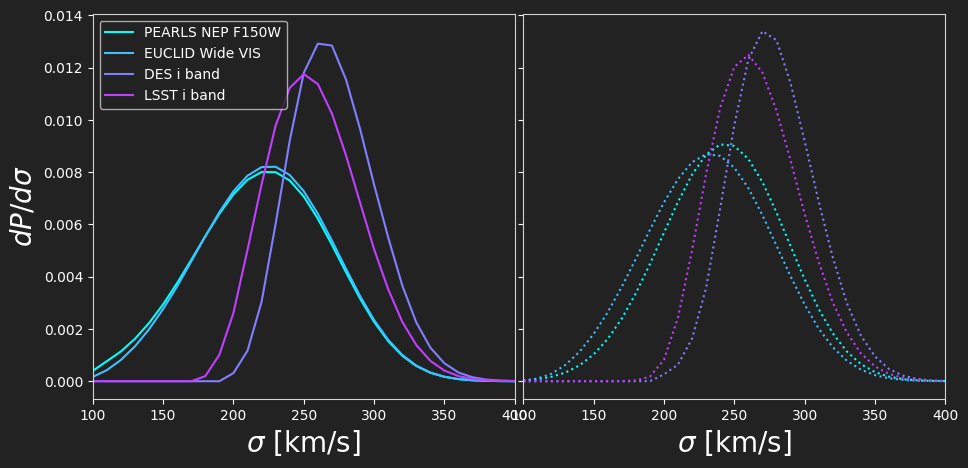

In [14]:
surveys_selection = ['PEARLS NEP F150W', 'EUCLID Wide VIS', 'DES i band', 'LSST i band']
#surveys_selection = ['COSMOS Web F115W', 'COSMOS Web F150W', 'COSMOS Web F277W']
#surveys_selection = surveys_titles
lens_plot.compare_z_distributions_surveys(surveys_selection, sigma_array, zl_array, zs_array, PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)
lens_plot.compare_sigma_distributions_surveys(surveys_selection, sigma_array, zl_array, zs_array, PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)

![Alt text](image.png)

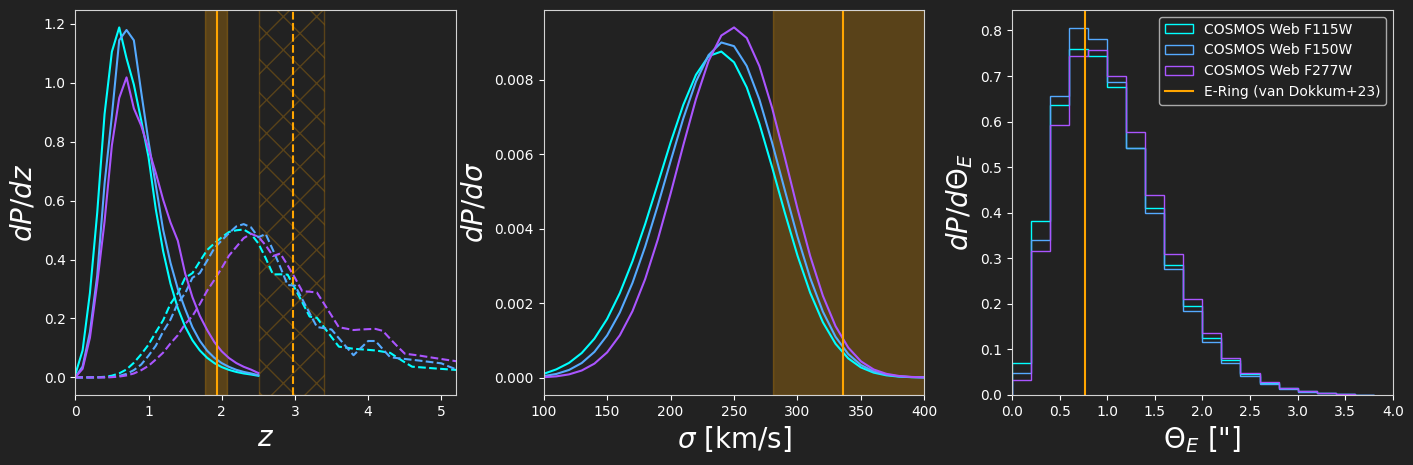

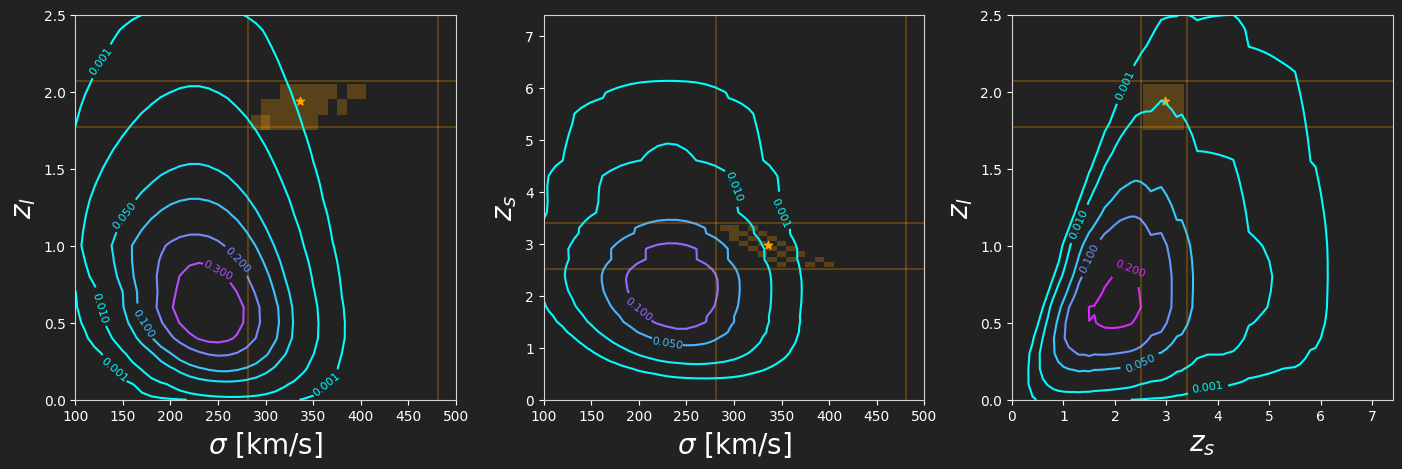

Prob of seeing this zl/zs/R_E config: 0.0030 deg^-2

[18 19 20 18 19 20 18 19 20 18 19 20 18 19 20 18 19 20 18 19 20 18 19 20]
[25 28 30 24 26 29 23 25 27 22 24 26 21 23 25 20 22 24 20 21 23 19 20 22]

[26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31 32 32 32 33 33 33]
[25 28 30 24 26 29 23 25 27 22 24 26 21 23 25 20 22 24 20 21 23 19 20 22]


In [15]:
lens_plot.compare_COSMOS_Web_Ering(zl_array, zs_array, sigma_array, PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___)

E_ring_rad     = 1.54/2 #" 
zl, spzl, smzl = 1.94,   0.13,   0.17
zs, spzs, smzs = 2.98,   0.42,   0.47
Ml, spMl, smMl = 6.5e11, 3.7e11, 1.5e11
sg, spsg, smsg = 336   , 145   , 55
CW_ER_rd, CW_ER_zl, CW_ER_zs, CW_ER_Ml, CW_ER_sg =  E_ring_rad, [zl, spzl, smzl], [zs, spzs, smzs], [Ml, spMl, smMl], [sg, spsg, smsg]

CHECK_LL = 0
COSMOS_JWST_surveys = ['COSMOS Web F115W', 'COSMOS Web F150W', 'COSMOS Web F277W']
title = COSMOS_JWST_surveys[0]

p_conf = ls.prob_for_obs_conf_in_param_space_per_sq_degree(title, CW_ER_zl, CW_ER_zs, E_ring_rad, zs_array, zl_array, sigma_array, CHECK_LL = 0)
print(f'Prob of seeing this zl/zs/R_E config: {p_conf:.4f} deg^-2')
print()
sss, lll, ggg = ls.get_param_space_idx_from_obs_constraints(CW_ER_zl, CW_ER_zs, E_ring_rad, zs_array, zl_array, sigma_array)
print(sss)
print(ggg)
print()
print(lll)
print(ggg)

In [16]:
def get_param_space_idx_from_obs_constraints(CW_ER_zl, CW_ER_zs, E_ring_rad, zs_array, zl_array, sigma_array):
    m_sg = np.zeros((len(zs_array), len(zl_array)))
    for izs, _zs in enumerate(zs_array):
        for izl, _zl in enumerate(zl_array):
            if((_zs>_zl) and (_zs>CW_ER_zs[0]-CW_ER_zs[2]) and (_zs<CW_ER_zs[0]+CW_ER_zs[1])):
                if((_zl>CW_ER_zl[0]-CW_ER_zl[2]) and (_zl<CW_ER_zl[0]+CW_ER_zl[1])):
                    m_sg[izs][izl] = sigma_from_R_Ein(_zs, _zl, E_ring_rad)
    sig_nozero_idx = np.zeros(0).astype(int)
    for sg_from_RE in m_sg[np.where(m_sg > 0)]:
            sig_nozero_idx = np.append(sig_nozero_idx, int(np.argmin(np.abs(sigma_array-sg_from_RE))))
    zs_nozero_idx, zl_nozero_idx = np.where(m_sg > 0)[0], np.where(m_sg > 0)[1]
    return zl_nozero_idx, zs_nozero_idx, sig_nozero_idx

def prob_for_obs_conf_in_param_space_per_sq_degree(survey_title, 
                                                    CW_ER_zl, CW_ER_zs, E_ring_rad,
                                                    zs_array, zl_array, sigma_array, CHECK_LL = True):
    survey_params = utils.read_survey_params(survey_title, VERBOSE = 0)
    area     = survey_params['area']
    matrix_LL, Theta_E_LL, prob_LL, matrix_noLL, Theta_E_noLL, prob_noLL = utils.load_pickled_files(survey_title)
    Ngal_zl_sigma_LL, Ngal_zs_sigma_LL, Ngal_zs_zl_LL, _ , __ , ___ = get_N_and_P_projections(matrix_LL, sigma_array, zl_array, zs_array, SMOOTH=1)
    mat = matrix_LL if CHECK_LL else matrix_noLL
    res = 0
    zl_nozero_idx, zs_nozero_idx, sig_nozero_idx = get_param_space_idx_from_obs_constraints(CW_ER_zl, CW_ER_zs, E_ring_rad, zs_array, zl_array, sigma_array)
    for src, sig, lns in zip(zs_nozero_idx, sig_nozero_idx, zl_nozero_idx):
        res = res + mat[src][sig][lns]
    return res/area

In [17]:
utils.print_summary_surveys(surveys_titles)

|     Survey - Filter     | PSF/Seeing ["] | Area [deg^2] | m_cut [mag] | m_lim [mag] | N [deg^-1] | N_lenses (LL)      |

|    COSMOS Web F115W     |           0.040|         0.540|         26.8|         27.1|         146|       79 (       39)

|    COSMOS Web F150W     |           0.050|         0.540|         26.4|         27.4|         140|       76 (       20)

|    COSMOS Web F277W     |           0.092|         0.540|         27.0|         28.0|         276|      149 (       24)

|    PEARLS NEP F115W     |           0.040|         0.015|         27.8|         28.8|         419|        6 (        2)

|    PEARLS NEP F150W     |           0.050|         0.015|         27.9|         28.9|         529|        8 (        2)

|    PEARLS NEP F277W     |           0.092|         0.015|         27.8|         28.8|         527|        8 (        1)

|    JADES Deep F115W     |           0.040|         0.007|         28.8|         29.8|         918|        6 (        2)

|    JADES Deep 

In [20]:
if(1):
    z = 1.7
    z_sigma = 0.5
    M_sat, M_min, sigma_logM, alpha = 10**14.18, 10**12.46, 0.2, 1.0
    #M_sat, M_min, sigma_logM, alpha = 10**12.08, 10**11.16, 0.2, 1.0
    z_array = np.array([1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3])
elif(0):
    z = 3.8
    z_sigma = 0.5
    M_sat, M_min, sigma_logM, alpha = 10**15.25, 10**13.08, 0.2, 1.0
    #M_sat, M_min, sigma_logM, alpha = 10**14.80, 10**12.71, 0.2, 1.0
    z_array = np.array([3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4])
elif(0):
    z = 4.9
    z_sigma = 0.5
    M_sat, M_min, sigma_logM, alpha = 10**16.65, 10**12.95, 0.2, 1.0
    #M_sat, M_min, sigma_logM, alpha = 10**14.80, 10**12.71, 0.2, 1.0
    z_array = np.array([4.5, 4.7, 4.9, 5.1])
elif(0):
    #random
    z = 4
    M_sat, M_min, sigma_logM, alpha = 2.4e12, 1.6e11, 0.2, 0.5
    z_array = np.array([1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3])

M_h_array, HMF_array, nu_array, hmf_k, hmf_PS = HOD.init_lookup_table(z)
NTOT = HOD.N_tot(M_h_array, M_sat, alpha, M_min, sigma_logM)
N_g_AVG = HOD.get_AVG_N_tot(M_min, sigma_logM, M_sat, alpha, z)
M_h_AVG = HOD.get_AVG_Host_Halo_Mass(M_min, sigma_logM, M_sat, alpha, z)
b_eff = HOD.get_EFF_gal_bias(M_min, sigma_logM, M_sat, alpha, z, USE_MY_BIAS = 0)
f_sat = HOD.get_AVG_f_sat(M_min, sigma_logM, M_sat, alpha, z)
n_avg = HOD.get_N_dens_avg(z_array, M_min, sigma_logM, M_sat, alpha, z, z_sigma)

print(f'redshift z   : {z:.2f}')
print(f'n_avg        : {n_avg:.2e}')
print(f'N_g_AVG      : {N_g_AVG:.2e}')
print(f'log(M_h_AVG) : {np.log10(M_h_AVG):.2f}')
print(f'b_eff        : {b_eff:.2f}')
print(f'log(f_sat)   : {np.log10(f_sat):.2f}')

FOLDERPATH = os.path.split(os.path.dirname(os.path.abspath('')))[0]+'/GALESS/galess/data/omega/'
_theta_arcsec = np.logspace(-1,3.333334,14)
if(0):
    theta = _theta_arcsec * 1/206265 # 1 arcsec in rad
    omega1h, omega2h = HOD.omega_array(theta, M_min, sigma_logM, M_sat, alpha, z, z_sigma, z_array)

    np.savetxt(FOLDERPATH + 'omega_1h_z'+str(int(z))+'_'+str(int(np.around(z%1, 2)*100))+'.txt', omega1h)
    np.savetxt(FOLDERPATH + 'omega_2h_z'+str(int(z))+'_'+str(int(np.around(z%1, 2)*100))+'.txt', omega2h)
omega1h = np.loadtxt(FOLDERPATH + 'omega_1h_z'+str(int(z))+'_'+str(int(np.around(z%1, 2)*100))+'.txt')
omega2h = np.loadtxt(FOLDERPATH + 'omega_2h_z'+str(int(z))+'_'+str(int(np.around(z%1, 2)*100))+'.txt')

COL = 'w' if ___PLOT_FOR_KEYNOTE___ else 'k'
line_c, cmap_c, _col_, col_A, col_B, col_C, col_D, fn_prefix = lens_plot.set_plt_param(___PLOT_FOR_KEYNOTE___)
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
ax.plot(_theta_arcsec, omega1h, c = COL,ls = '--', label=r'$\omega_{1h}$')
ax.plot(_theta_arcsec, omega2h, c = COL,ls = '-.', label=r'$\omega_{2h}$')
ax.plot(_theta_arcsec, omega1h+omega2h, c = COL,ls = '-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((0.5,2e3))
ax.set_ylim((1e-3,4e0)) if z < 3.7 else ax.set_ylim((1e-2,4e1))
ax.set_xlabel(r'$\theta$ [arcsec]')
ax.set_ylabel(r'$\omega$($\theta$)')
plt.legend()
plt.show()

Calculating HMF table at redshift 1.10


/Users/giofer/anaconda3/envs/HOD/lib/python3.11/site-packages/hmf/mass_function/fitting_functions.py:1600: RuntimeWarning: divide by zero encountered in log10
  ngtm_behroozi = 10 ** (theta + np.log10(ngtm_tinker))
/Users/giofer/anaconda3/envs/HOD/lib/python3.11/site-packages/hmf/density_field/halofit.py:107: UserWarning: sigma_8 is not used any more, and will be removed in v4
  warnings.warn("sigma_8 is not used any more, and will be removed in v4")


Calculating HMF table at redshift 2.30
redshift z   : 1.70
n_avg        : 3.79e-04
N_g_AVG      : 4.04e-04
log(M_h_AVG) : 12.81
b_eff        : 2.58
log(f_sat)   : -1.42


FileNotFoundError: /Users/giofer/Documents/GitHub/GALESS/galess/data/omega/omega_1h_z1_70.txt not found.

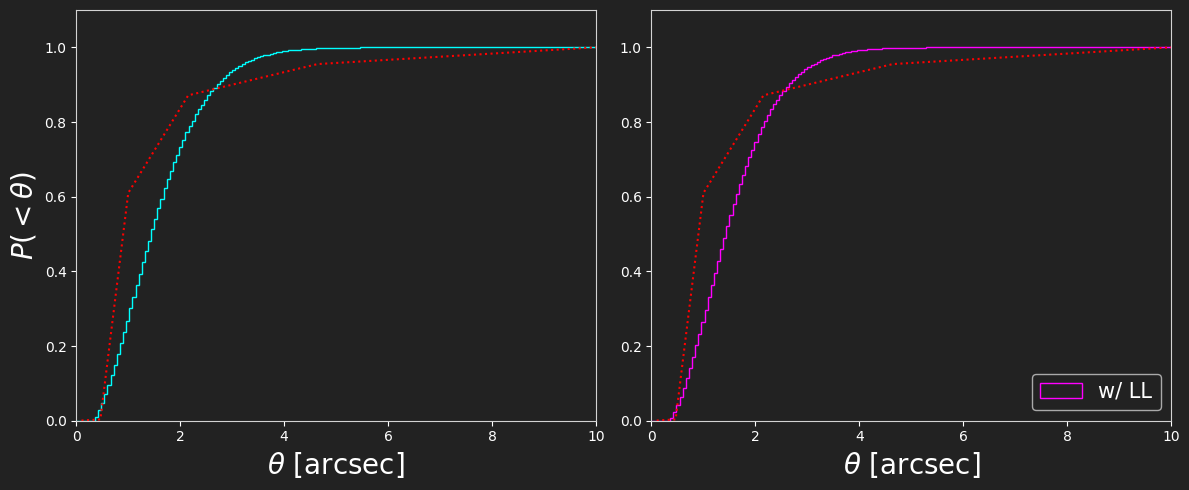

In [19]:
lens_plot.plot_angular_separation('EUCLID Wide VIS', zs_array, (omega1h+omega2h),  SPLIT_REDSHIFTS = 0, PLOT_ACF = 0, PLOT_FOR_KEYNOTE = ___PLOT_FOR_KEYNOTE___ )